In [1]:
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
from astropy.cosmology import WMAP9 as cosmo
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]
# Calculate the fraction of data that remains
fraction_remaining = len(k_gg) / len(k['k_gg'])
print(f"Fraction of data that remained: {fraction_remaining:.2f}")

Fraction of data that remained: 1.00


In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z = d['Z'][SEL][~indice]
TARGETID = d['TARGETID'][SEL][~indice]
d = Planck18.distmod(z).value

In [4]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
apr_mag_g = apr_mag_g[indices]
apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d = d[indices]
z = z[indices]
k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [5]:
mag_r_bins = np.linspace(np.min(apr_mag_r), np.max(apr_mag_r), 40)
z_bins = np.linspace(np.min(z), np.max(z), 10)
counts_r,z_edges,mag_r_edges= np.histogram2d(z, apr_mag_r, bins=[z_bins, mag_r_bins])

In [6]:
mag_r_bin_widths = np.diff(mag_r_bins)[0]  # Differences between consecutive bin edges for magnitude
z_bin_widths = np.diff(z_bins)[0]          # Differences between consecutive bin edges for redshift

(array([11109., 10382., 10392., 10240.,  9673.,  9294.,  9047.,  8696.,
         8458.,  8105.,  7429.,  6943.,  6868.,  6733.,  6438.,  6027.,
         5737.,  5560.,  5455.,  5155.]),
 array([2.30000261, 2.32500184, 2.35000107, 2.3750003 , 2.39999952,
        2.42499875, 2.44999798, 2.47499721, 2.49999644, 2.52499566,
        2.54999489, 2.57499412, 2.59999335, 2.62499257, 2.6499918 ,
        2.67499103, 2.69999026, 2.72498949, 2.74998871, 2.77498794,
        2.79998717]),
 <BarContainer object of 20 artists>)

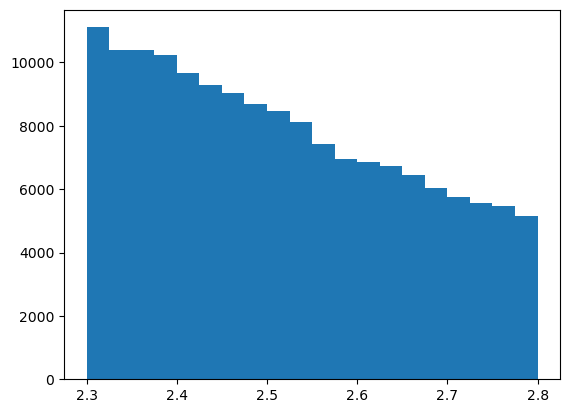

In [7]:
plt.hist(z,bins=20)

In [8]:
def comoving_volume(z1,z2):
    """
    Calculate the comoving volume between two redshifts.
    
    Args:
        z1 (float): Lower redshift bound
        z2 (float): Upper redshift bound
    
    Returns:
        float: Comoving volume in cubic megaparsecs (Mpc^3)
    """
    d1 = cosmo.comoving_distance(z1).value# Mpc
    d2 = cosmo.comoving_distance(z2).value# Mpc
    return 4/3 * np.pi * (d2**3 - d1**3)  # Mpc^3

In [9]:
phi_r = np.zeros_like(counts_r)
volumes = np.array([comoving_volume(z_edges[i], z_edges[i+1]) for i in range(len(z_edges)-1)]) 
delta_m_r = np.diff(mag_r_bins)
for i in range(len(z_bins)-1):
    for j in range(len(mag_r_bins)-1):
        phi_r[i, j] = counts_r[i, j] / (volumes[i] * delta_m_r[j])/0.16
print(phi_r.shape)

(9, 39)


In [10]:
def phi1(m,z1, z2):
    indices = np.where((z > z1) & (z < z2))
    k_mean = np.mean(k_rr[indices])
    new_z = (z1+z2)/2
    new_d = Planck18.distmod(new_z).value
    L = abs_mag_to_L(m - k_mean - new_d+0.74)
    phi1 = 0.4*get_phis(L,new_z,"shen20")
    return phi1

In [11]:
phi_r_prediction = np.zeros((len(z_bins)-1, len(mag_r_bins)-1))

for i in range(len(z_bins)-1):    
    for j in range(len(mag_r_bins)-1):
        m_mid = 0.5 * (mag_r_bins[j] + mag_r_bins[j+1])
        phi_r_prediction[i,j] = phi1(m_mid,z_bins[i],z_bins[i+1])

/tmp/ipykernel_153370/2445230473.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.plot(mag_r_cens, np.log10(phi_r[i,:]),label='DESI')


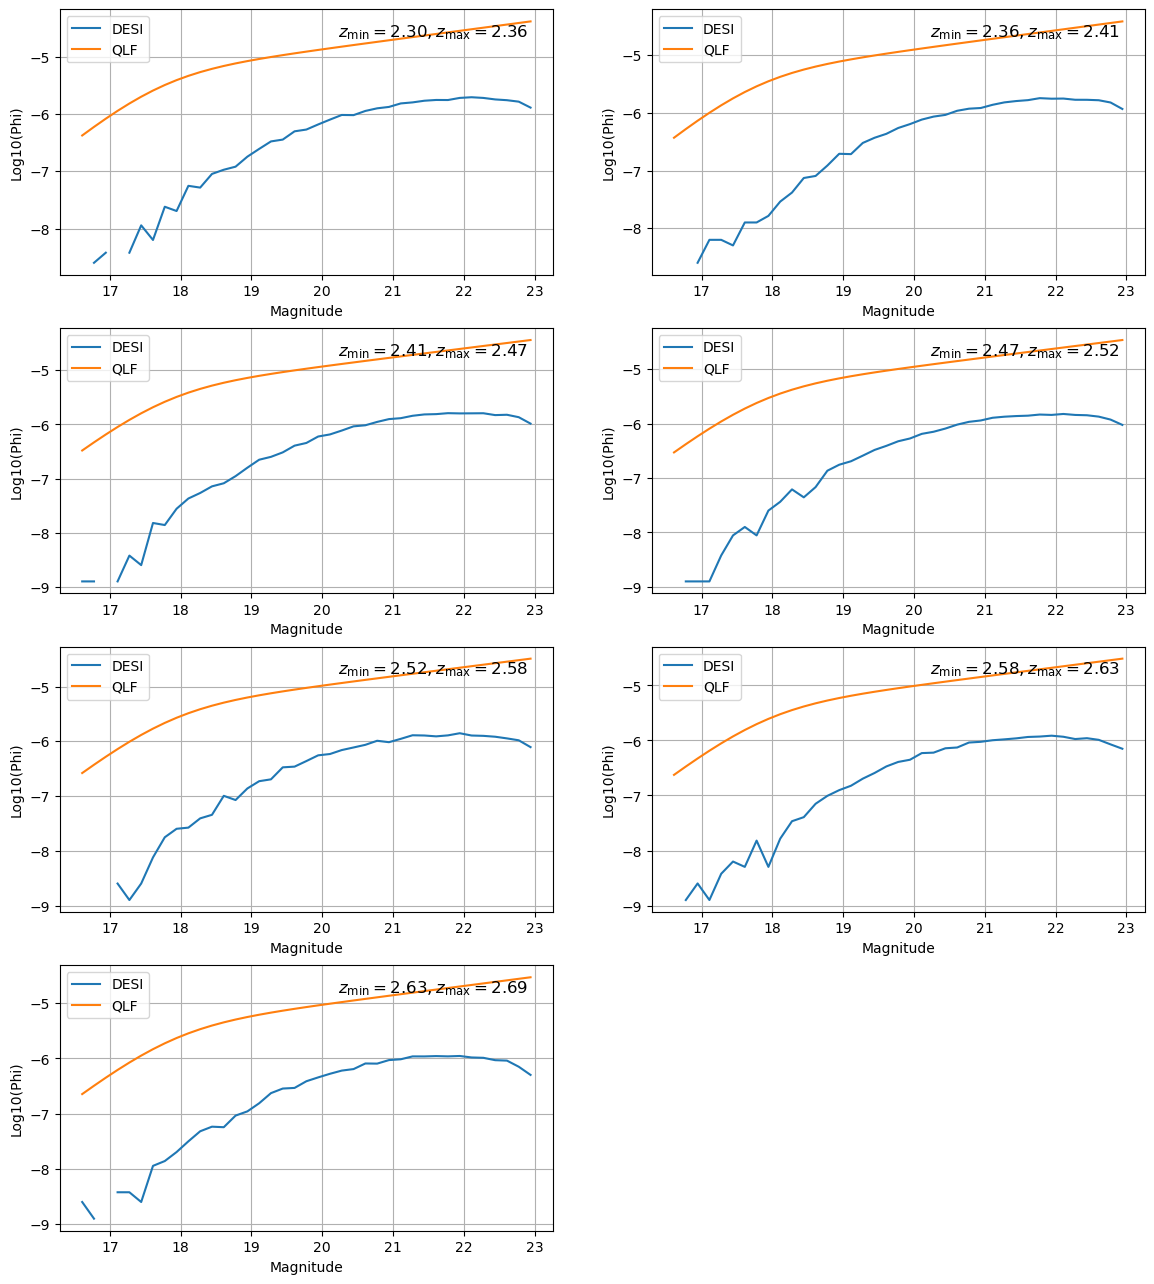

In [12]:
from matplotlib import gridspec
fig = plt.figure(figsize=(14, 20))
gs = gridspec.GridSpec(5, 2, hspace=0.2, wspace=0.2)

for i in range(0,7):
    mag_r_cens = 0.5*(mag_r_bins[1:]+mag_r_bins[:-1])
    ax = plt.subplot(gs[i])
    ax.plot(mag_r_cens, np.log10(phi_r[i,:]),label='DESI')
    ax.plot(mag_r_cens,np.log10(phi_r_prediction[i,:]),label='QLF')
    ax.grid()
    ax.set_xlabel('Magnitude')  # Label for the x-axis
    ax.set_ylabel('Log10(Phi)')  # Label for the y-axis
    #ax.set_xlim([-32, -25])  # Adjust x-axis limits
    #ax.set_ylim([-9, -4])
    ax.legend(loc='upper left')
    ax.text(0.95, 0.95, f'$z_{{\min}} = {z_bins[i]:.2f}, z_{{\max}} = {z_bins[i+1]:.2f}$', fontsize=12, ha='right', va='top', transform=ax.transAxes)
plt.show()

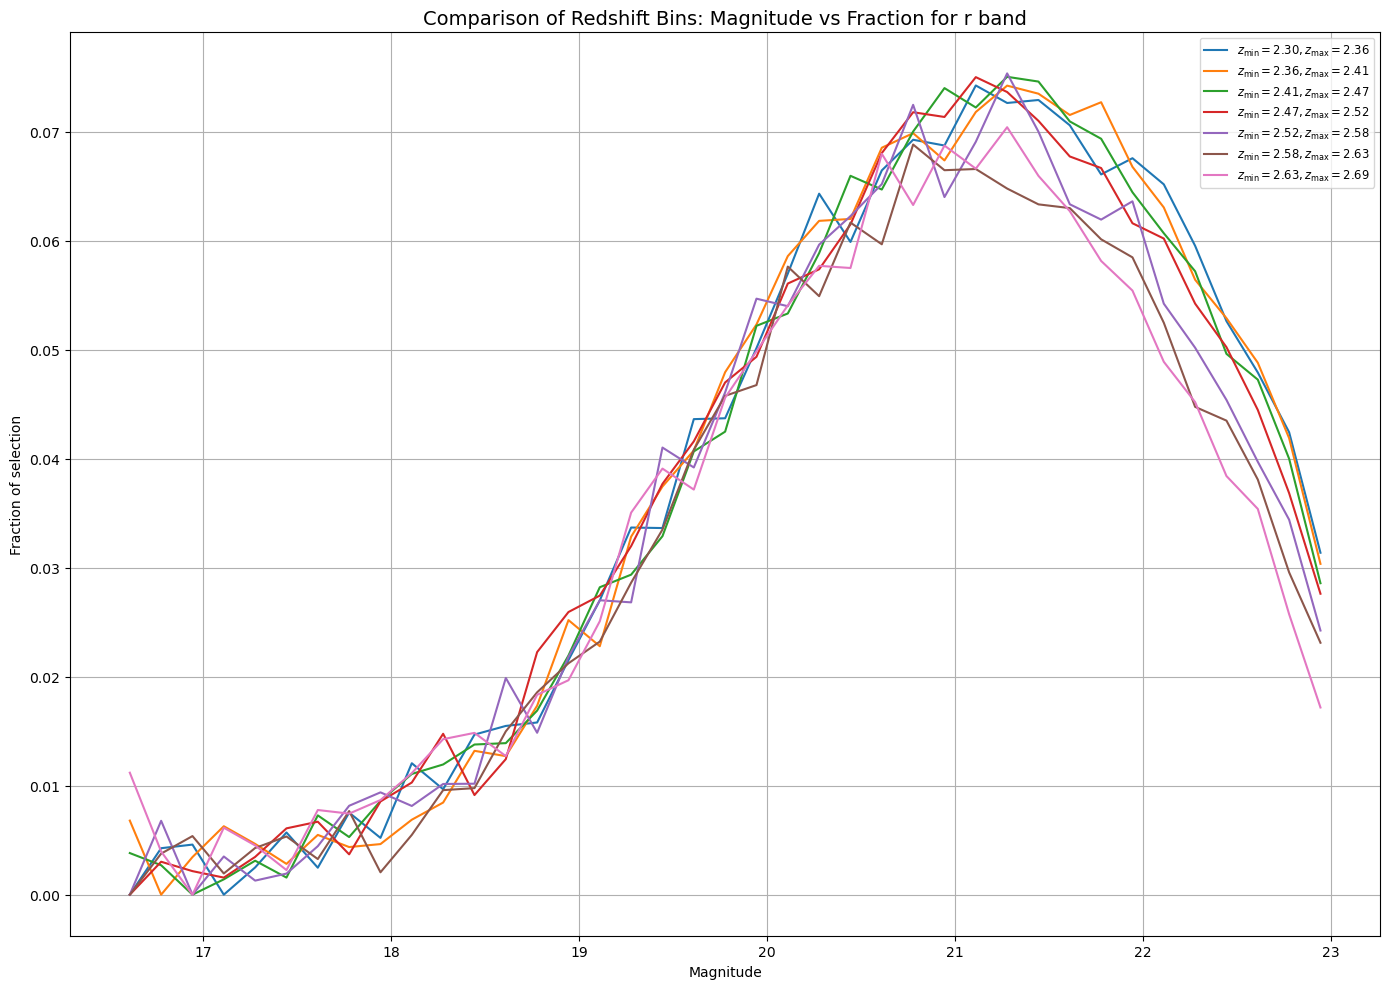

In [13]:
from matplotlib import gridspec

# Create a figure with a single set of axes
fig, ax = plt.subplots(figsize=(14, 10))

mag_r_cens = 0.5 * (mag_r_bins[1:] + mag_r_bins[:-1])

# Plot each dataset on the same axes
for i in range(7):  # Adjust to 10 if there are 10 bins
    ax.plot(mag_r_cens, phi_r[i, :] / phi_r_prediction[i, :], label=f'$z_{{\min}} = {z_bins[i]:.2f}, z_{{\max}} = {z_bins[i+1]:.2f}$')

ax.grid(True)
ax.set_xlabel('Magnitude')  # Label for the x-axis
ax.set_ylabel('Fraction of selection')  # Label for the y-axis
#ax.set_xlim([-32, -25])  # Adjust x-axis limits
# ax.set_ylim([-9, -4])  # Adjust y-axis limits if needed
ax.legend(loc='upper right', fontsize='small')  # Adjust legend location and size for clarity

plt.title('Comparison of Redshift Bins: Magnitude vs Fraction for r band', fontsize=14)
plt.tight_layout()
plt.savefig('/global/u1/z/zhaozhon/Plots/fraction_r.png', dpi=300)
plt.show()

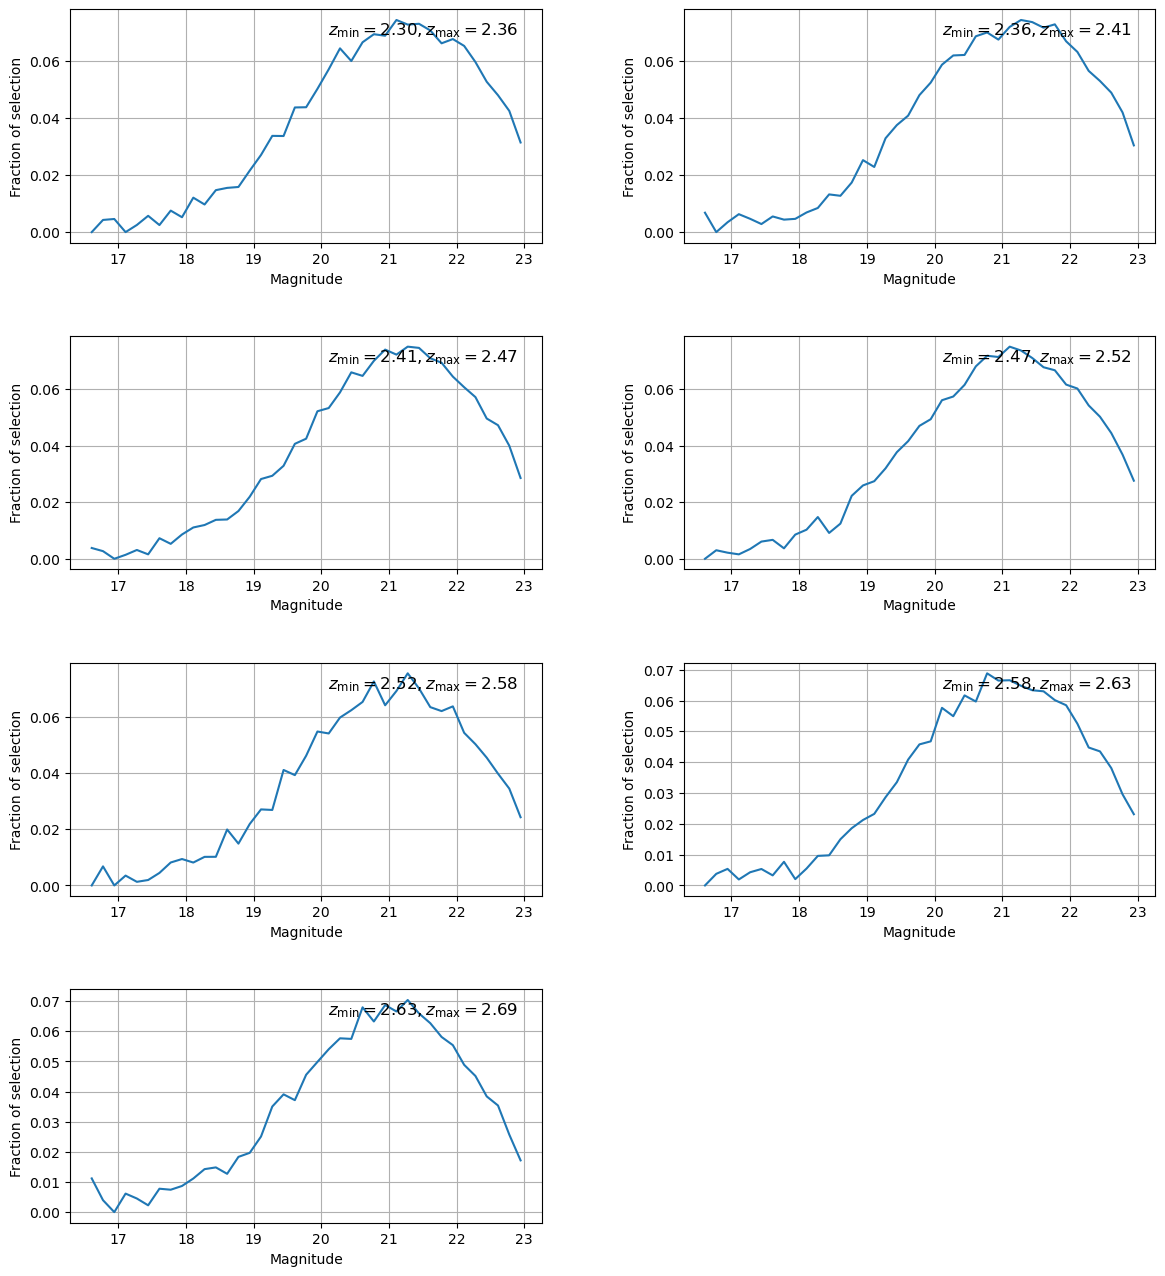

In [14]:
from matplotlib import gridspec
fig = plt.figure(figsize=(14, 20))
gs = gridspec.GridSpec(5, 2, hspace=0.4, wspace=0.3)

for i in range(0,7):
    mag_r_cens = 0.5*(mag_r_bins[1:]+mag_r_bins[:-1])
    new_mag_r_cens = 0.5*(mag_r_bins[1:]+mag_r_bins[:-1])
    ax = plt.subplot(gs[i])
    ax.plot(mag_r_cens, phi_r[i,:]/phi_r_prediction[i,:],label='DESI')
    ax.grid()
    ax.set_xlabel('Magnitude')  # Label for the x-axis
    ax.set_ylabel('Fraction of selection')  # Label for the y-axis
    #ax.set_xlim([-32, -25])  # Adjust x-axis limits
    #ax.set_ylim([-9, -4])
    #ax.legend(loc='upper left')
    ax.text(0.95, 0.95, f'$z_{{\min}} = {z_bins[i]:.2f}, z_{{\max}} = {z_bins[i+1]:.2f}$', fontsize=12, ha='right', va='top', transform=ax.transAxes)

plt.show()